<a href="https://colab.research.google.com/github/bicalabs/locallearning/blob/master/snn_hebian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [18]:
import tensorflow as tf
import math


class SpikingLayer(tf.Module):
  def __init__(self, dim = 256, threshold = tf.constant(10.), decay = 2, **kwargs):
    super().__init__(**kwargs)

    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    # Setting dimenstionality
    self.dim = dim

    # Initialize layers
    self.weights = tf.Variable(tf.random.uniform((dim, dim), minval = 0., maxval = 255.))
    
  def __call__(self, input, train: bool):
    input = tf.reshape(input, [1, -1])
    output = tf.clip_by_value(input @ self.weights / (255 * 255.) - self.threshold, 0., 255.)
    if train:
      map = output + tf.constant(0.0, shape = (self.dim, self.dim))
      loss = tf.cos((self.weights - 127.) / 256. * math.pi) * (1. - tf.clip_by_value(map, 0., 1.))
      self.weights = self.weights / (loss * self.decay + 1.) + (tf.sigmoid(self.weights * map) - 0.5) * 255.
    return output


class HebianNet(tf.Module):
  def __init__(self, dim = 256, layer_count = 10, threshold = tf.constant(10.), decay = 2., seed = 487624, **kwargs):
    super().__init__(**kwargs)

    # Initialize seed for better determinism
    self.seed = seed
    tf.random.set_seed(seed)
    
    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    # Setting dimenstionality
    self.dim = dim

    self.layers = []
    self.layer_count = layer_count
    for layer_no in range(0, layer_count):
      self.layers.append(SpikingLayer(dim, threshold, **kwargs))

  def __call__(self, input, train: bool):
    input = tf.cast(input, tf.float32)
    for layer in self.layers:
      output = layer(input, train)
      input = output
    return output


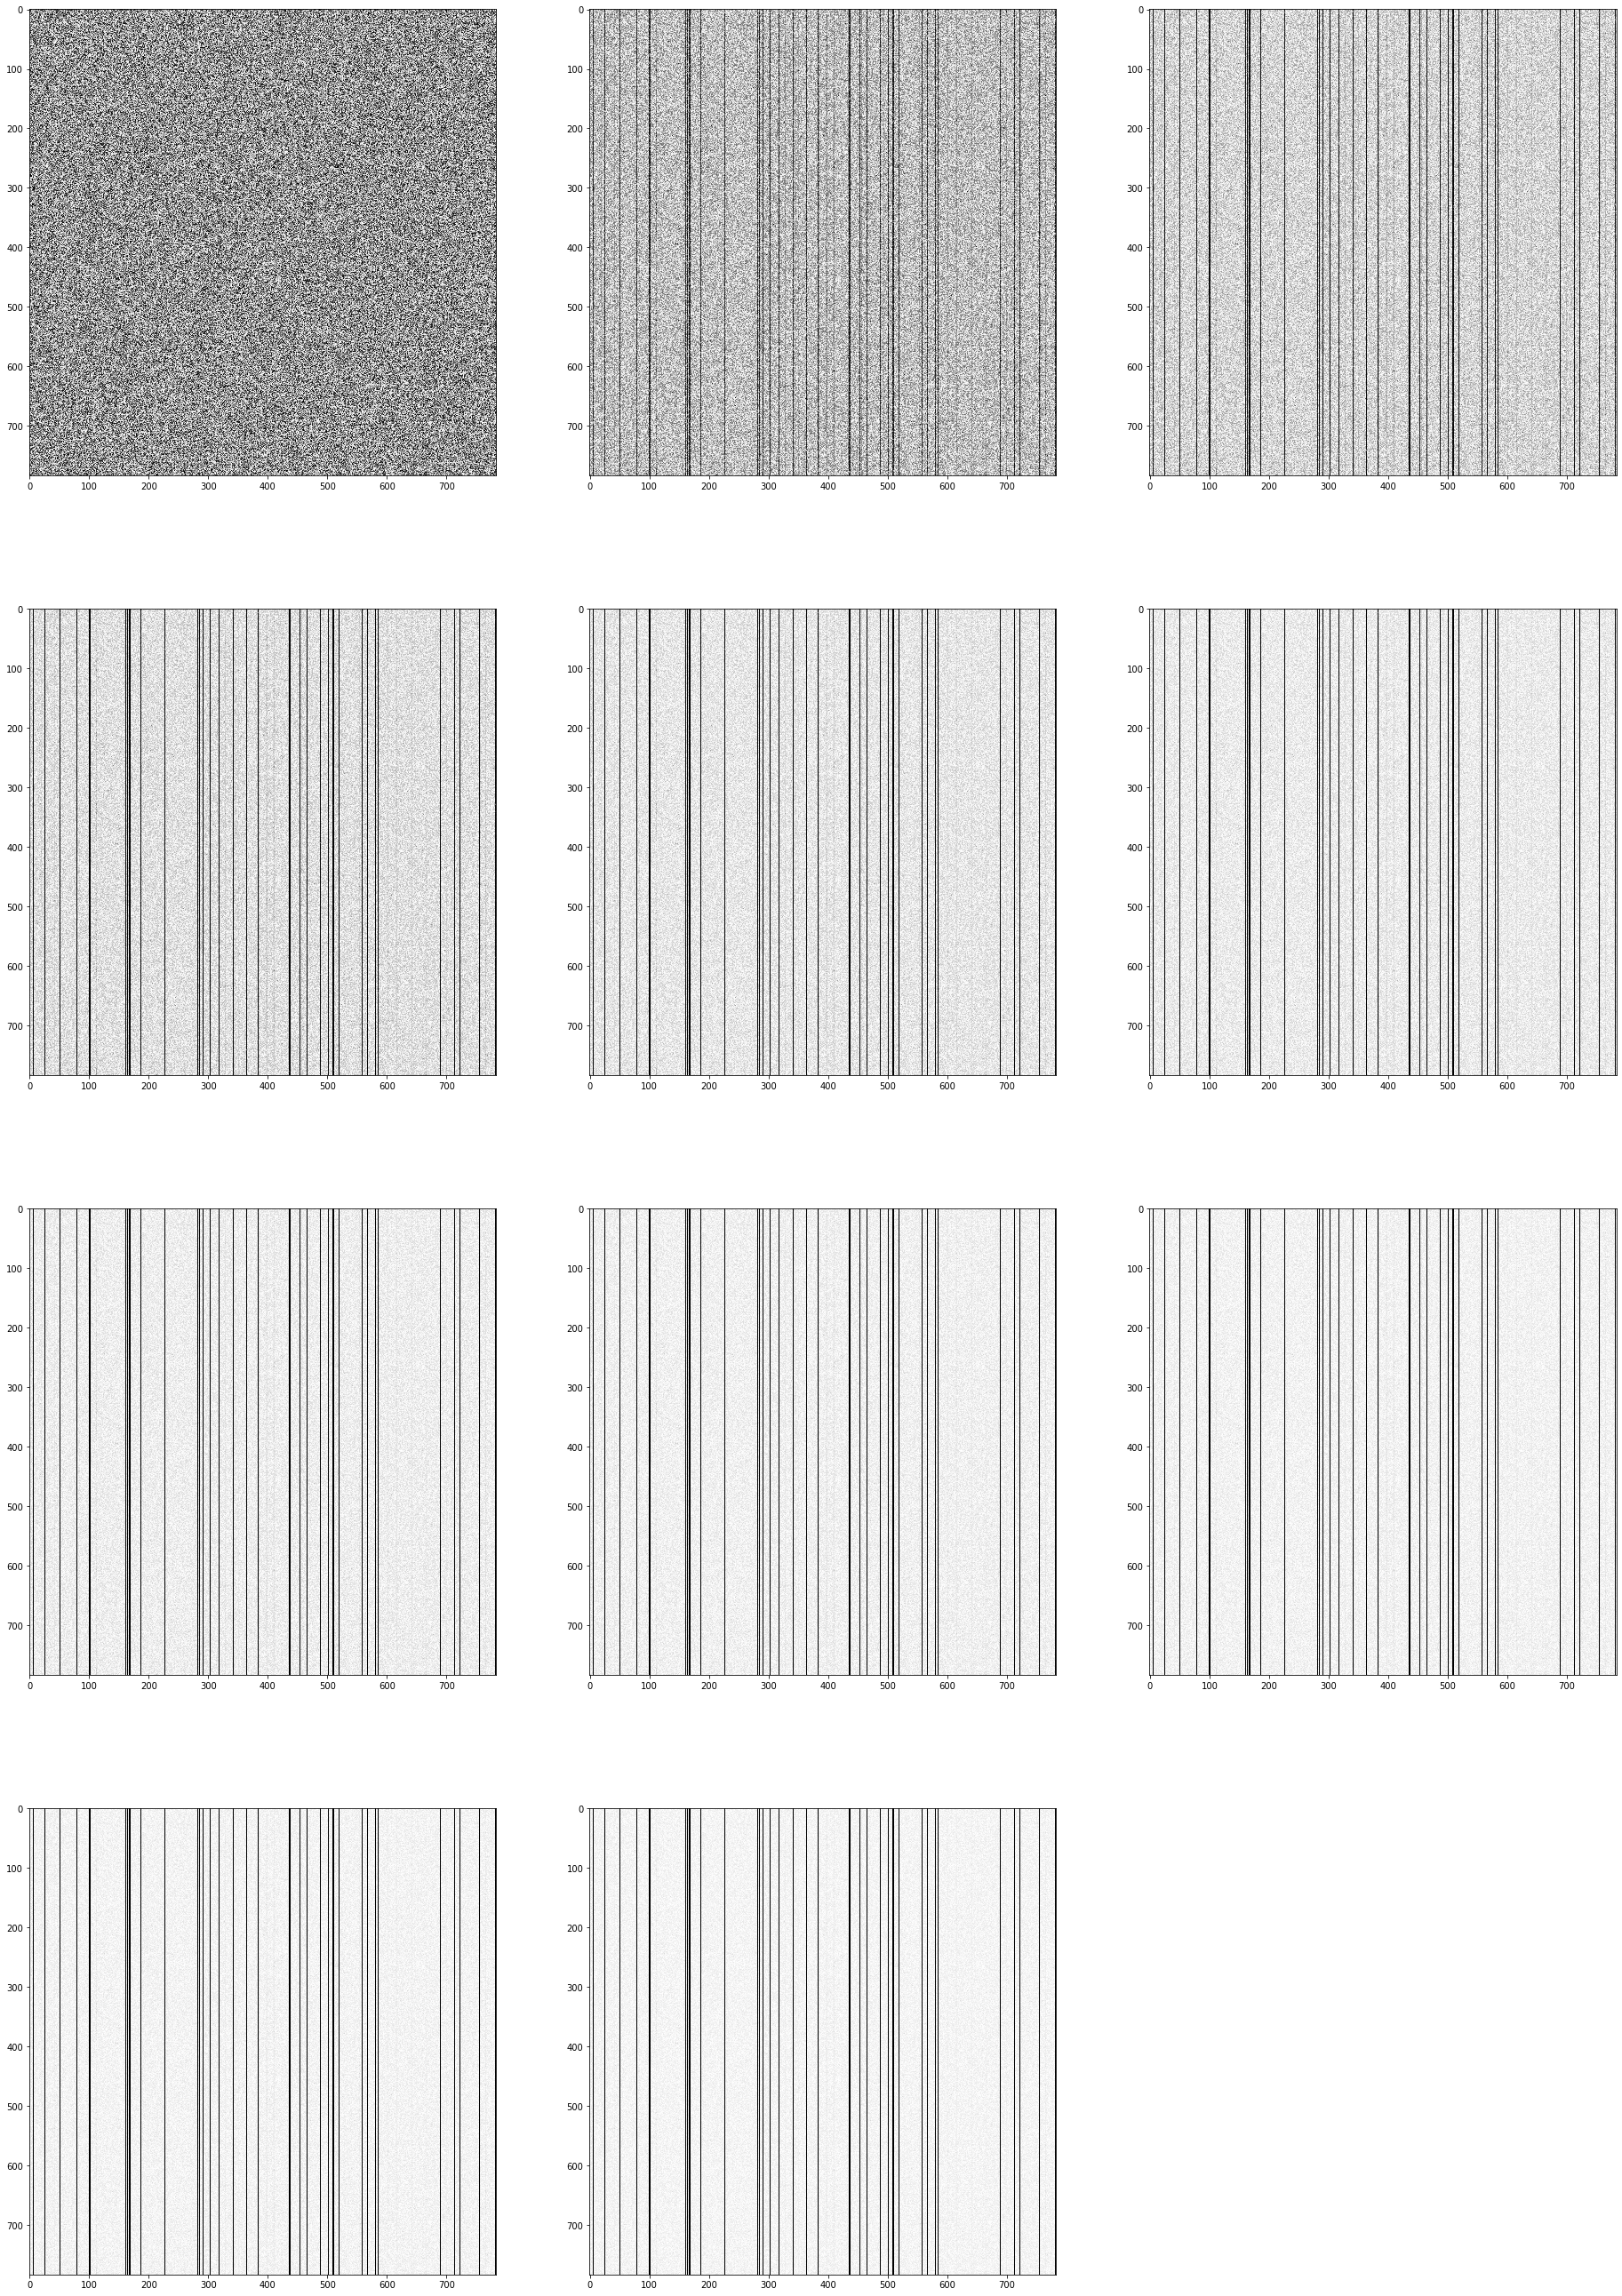

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
data = tf.reshape(x_train, (-1, 28 * 28))

snn = HebianNet(dim = 28 * 28, layer_count = 1, threshold = 50., decay = 10.)

fig = plt.figure(figsize=(32, 12*5))
ax1 = fig.add_subplot(5, 3, 1)
ax1.imshow(snn.layers[0].weights, interpolation='nearest', cmap=cm.Greys_r)

shape = data.shape.as_list()
for no in range(0, 10):
  snn(data[no], True)
  ax2 = fig.add_subplot(5, 3, 2 + no)
  ax2.imshow(snn.layers[0].weights, interpolation='nearest', cmap=cm.Greys_r)

